In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/test'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['age'].keys()))
print(len(subs))

830


In [2]:
import numpy as np

task = 'emoid'
x = []
y = []

for sub in subs:
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(int(demo['age'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(830, 34716)
(830,)
[116 187 190 242 137]


In [110]:
from sklearn.model_selection import train_test_split

import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class Basis(nn.Module):
    def __init__(self, dim):
        super(Basis, self).__init__()
        self.A = nn.Parameter(torch.randn(dim,264,1).float().cuda())
        
    def compute(self, dim=0):
        A = self.A[dim]
        A = A@A.T
        a,b = torch.triu_indices(264,264,offset=1)
        return A[a,b]
    
    def to_img(self, dim=0):
        A = self.A[dim]
        A = A@A.T
        return A.detach().cpu().numpy()
    
xtr, xt, ytr, yt = train_test_split(x, y, train_size=0.8)

xtr = torch.from_numpy(xtr).float().cuda()
xt = torch.from_numpy(xt).float().cuda()
ytr = torch.from_numpy(ytr).float().cuda()
yt = torch.from_numpy(yt).float().cuda()

mu = torch.mean(ytr)
ytr = ytr-mu
yt = yt-mu
    
w = nn.Parameter(torch.randn(1,len(ytr)).float().cuda())
u = nn.Parameter(torch.randn(1).float().cuda())
    
basis = Basis(1)
optim = torch.optim.Adam(basis.parameters(), lr=1e-2, weight_decay=1e-4)

nepochs = 500
pperiod = 10

for epoch in range(nepochs):
    optim.zero_grad()
    A = basis.compute()
    A = A.unsqueeze(1)
    w,_,_,_ = torch.linalg.lstsq(A, xtr.T)
    xhat = (A@w).T
    u,_,_,_ = torch.linalg.lstsq(w.T, ytr)
    yhat = w.T@u.detach()
    rloss = 1e4*torch.mean((xhat-xtr)**2)**0.5
    ploss = torch.mean((yhat-ytr)**2)**0.5
    (rloss+ploss).backward()
    optim.step()
    if epoch % pperiod == 0 or epoch == nepochs:
        print(f'{float(rloss)} {float(ploss)}')
        
print('Complete')

3941.446533203125 40.20319366455078
3941.4697265625 39.68477249145508
3941.463623046875 38.809200286865234
3941.45703125 38.12052917480469
3941.458984375 37.26435470581055
3941.463134765625 36.34934616088867
3941.462158203125 35.55546951293945
3941.462646484375 34.73734664916992
3941.46484375 33.89012145996094
3941.46533203125 33.005863189697266
3941.466552734375 32.085121154785156
3941.46728515625 31.13897705078125
3941.46826171875 30.193117141723633
3941.468505859375 29.395519256591797
3941.46923828125 28.743623733520508
3941.46923828125 28.14927101135254
3941.4697265625 27.59913444519043
3941.470458984375 27.067319869995117
3941.470458984375 26.56201934814453
3941.470703125 26.082616806030273
3941.470947265625 25.729984283447266
3941.47119140625 25.402393341064453
3941.47119140625 25.173192977905273
3941.471923828125 24.966644287109375
3941.471923828125 24.773021697998047
3941.471923828125 24.59054183959961
3941.471923828125 24.42244529724121
3941.47216796875 24.266178131103516
3941

In [90]:
tw = Weights(1, len(yt))

optim = torch.optim.Adam(tw.parameters(), lr=1e-2, weight_decay=1e-4)

nepochs = 1000
pperiod = 100

for epoch in range(nepochs):
    optim.zero_grad()
    A = basis.compute().detach()
    rloss = tw.recon_loss(A, xt)
    rloss.backward()
    optim.step()
    if epoch % pperiod == 0 or epoch == nepochs:
        print(f'{float(rloss)}')
        
print('Complete')

with torch.no_grad():
    yhat = basis.predict(tw.w).detach()
    print(yhat)

# with torch.no_grad():
#     A = basis.compute()
#     A = A.T #.unsqueeze(1)
#     w,_,_,_ = torch.linalg.lstsq(A.T@A, A.T@xt.T)
#     w = w.T
#     ploss = torch.mean((yt-w@u.detach())**2)**0.5
#     print(ploss)
#     ploss = torch.mean((yt-torch.mean(ytr))**2)**0.5
#     print(ploss)

0.38933753967285156
0.38836586475372314
0.3882009983062744
0.3881748914718628
0.3881714642047882
0.38817116618156433
0.38817116618156433
0.3881711959838867
0.3881711959838867
0.3881711959838867
Complete
tensor([-0.0060, -0.0191, -0.0151, -0.0151, -0.0219,  0.0083, -0.0142, -0.0223,
        -0.0160, -0.0019, -0.0238, -0.0170, -0.0329, -0.0294, -0.0190, -0.0319,
         0.0065, -0.0098, -0.0148, -0.0250, -0.0141, -0.0090, -0.0224, -0.0126,
        -0.0183, -0.0267, -0.0064, -0.0085, -0.0066,  0.0125,  0.0061, -0.0013,
         0.0044, -0.0262, -0.0061, -0.0084,  0.0040, -0.0204, -0.0297,  0.0045,
        -0.0060, -0.0149, -0.0231, -0.0122, -0.0083, -0.0184, -0.0264,  0.0368,
        -0.0299, -0.0176, -0.0104, -0.0052, -0.0117, -0.0065, -0.0059, -0.0153,
        -0.0321, -0.0257, -0.0179, -0.0395, -0.0254, -0.0090,  0.0230, -0.0229,
        -0.0081, -0.0089, -0.0249, -0.0151, -0.0305,  0.0168, -0.0179, -0.0212,
        -0.0132, -0.0255, -0.0047, -0.0085,  0.0060, -0.0124,  0.0091, -0.028

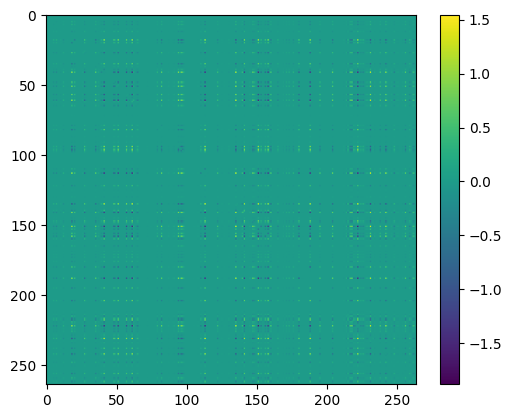

In [82]:
import matplotlib.pyplot as plt

def vec2mat(p):
    if isinstance(p, torch.Tensor):
        p = p.detach().cpu().numpy()
    m = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    m[a,b] = p
    return m+m.T

# plt.imshow(basis.to_img(0))
plt.imshow(vec2mat(weights.recon(basis.compute())[5]))
plt.colorbar()
plt.show()

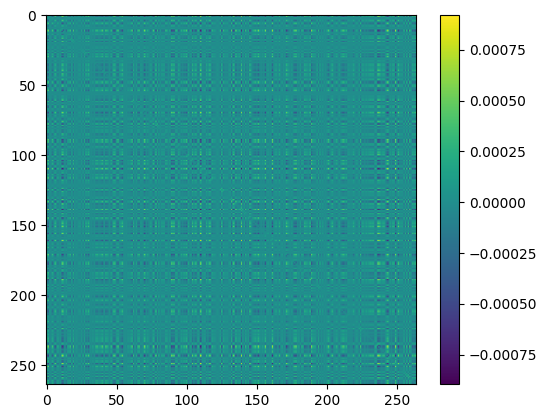

In [38]:
plt.imshow(vec2mat(rx[:,10])-vec2mat(xtr[10]))
plt.colorbar()
plt.show()

In [42]:
ws[2]

tensor([[2.5039],
        [1.4808],
        [2.5351],
        [2.5344],
        [2.0214],
        [1.6934],
        [1.2746],
        [2.4453],
        [2.3692],
        [2.4896],
        [2.7007],
        [2.1741],
        [1.6328],
        [1.6871],
        [1.9264],
        [2.4682],
        [2.4441],
        [2.3765],
        [1.9610],
        [1.7515],
        [1.5345],
        [3.0201],
        [3.0771],
        [2.8741],
        [2.3919],
        [2.6742],
        [2.9872],
        [2.1431],
        [2.2600],
        [3.2758],
        [2.8136],
        [3.2029],
        [3.3092],
        [1.7611],
        [1.9877],
        [1.5934],
        [1.6421],
        [1.9092],
        [2.4025],
        [2.5085],
        [2.0024],
        [2.8524],
        [1.2201],
        [1.9956],
        [3.2644],
        [2.0844],
        [2.0421],
        [2.3804],
        [2.5384],
        [2.3345],
        [2.8429],
        [2.0353],
        [1.7082],
        [1.4887],
        [2.1443],
        [2